In [14]:
import os
import json
import random
import xml.etree.ElementTree as ET
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, LSTM, Dense, GlobalAveragePooling1D, Concatenate, Add, Softmax,
    BatchNormalization, Multiply, Layer, Dropout, Reshape, LayerNormalization, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import register_keras_serializable


In [ ]:
# Data preprocessing
import os, json, math, random
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import functools

# Optional sklearn import for KNN imputation
try:
    from sklearn.impute import KNNImputer
    _HAS_SK = True
except Exception:
    _HAS_SK = False

# Time parsing
DTFMT = "%d-%m-%Y %H:%M:%S"
DTFMT_CANDIDATES = [
    DTFMT,
    "%d-%m-%Y %H:%M",
    "%Y-%m-%d %H:%M:%S",
    "%m/%d/%Y %H:%M:%S",
]

FREQ = "5min"                 # resample frequency
CGM_SHORT_GAP_LIMIT = 12      # max CGM gap length for interpolation (<= 60 min)
CGM_LONG_GAP_DAY_DROP = 24   # drop day if longest CGM gap >= 120 min
CONT_SHORT_GAP_LIMIT = 6      # max non-CGM gap length for interpolation
WINSOR_Q = (0.01, 0.99)       # winsorization quantiles
GLUCOSE_CLIP = (40, 400)     # physiologic glucose range

# On-board kernels (5 min sampling)
COB_GAMMA_A    = 3.0
COB_THETA_MIN  = 15.0
COB_TOTAL_MIN  = 240

IOB_GAMMA_A    = 3.0
IOB_THETA_MIN  = 30.0
IOB_TOTAL_MIN  = 360

AOB_GAMMA_A    = 2.0
AOB_THETA_MIN  = 60.0
AOB_TOTAL_MIN  = 720

# Use AOB-transformed exercise to overwrite exercise_intensity
USE_AOB_FOR_EXERCISE = True

# Utils
def safe_to_dt(ts):
    if ts is None:
        return pd.NaT
    for fmt in DTFMT_CANDIDATES:
        try:
            return pd.to_datetime(ts, format=fmt, dayfirst=True)
        except Exception:
            continue
    return pd.to_datetime(ts, errors="coerce", dayfirst=True)


def safe_float(v, default=np.nan):
    try:
        return float(v) if v is not None and str(v).strip() != "" else default
    except Exception:
        return default


def build_time_index(start, end, freq=FREQ):
    return pd.date_range(start=start, end=end, freq=freq)


def winsorize_series(s: pd.Series, lower=WINSOR_Q[0], upper=WINSOR_Q[1]):
    s = s.copy()
    if s.notna().sum() == 0:
        return s
    ql, qu = s.quantile([lower, upper])
    return s.clip(ql, qu)


def add_mask_delta(df: pd.DataFrame, cols, freq_min=5):
    """Generate *_mask and *_delta. mask=1 means observed, delta is minutes since last observation"""
    out = df.copy()
    t = df.index.to_series()
    for c in cols:
        m = df[c].notna()
        last_obs_time = t.where(m).ffill()
        delta = (t - last_obs_time).dt.total_seconds() / 60
        delta[m] = 0
        delta[last_obs_time.isna()] = np.nan
        out[c + "_mask"] = m.astype(float).values
        out[c + "_delta"] = delta.values
    return out

def longest_nan_run(s: pd.Series) -> int:
    """Return longest consecutive NaN run length (in samples)"""
    x = s.isna().to_numpy()
    if not x.any():
        return 0
    max_len = 0
    cur = 0
    for v in x:
        if v:
            cur += 1
            if cur > max_len:
                max_len = cur
        else:
            cur = 0
    return int(max_len)

# On-board calculations
@functools.lru_cache(maxsize=16)
def make_gamma_kernel(total_min=240, step_min=5, a=3.0, theta_min=15.0, zero_at_t0=True):
    """
    Build discrete causal gamma kernel, returns shape (L,) and sums to 1
    zero_at_t0=True sets k[0]=0
    """
    L = int(total_min // step_min) + 1
    t = np.arange(L, dtype=np.float32) * step_min
    k = (np.power(np.clip(t, 1e-6, None), a - 1.0) * np.exp(-t / theta_min)).astype(np.float32)
    if zero_at_t0:
        k[0] = 0.0
    s = k.sum()
    if s > 0:
        k = k / s
    return k.astype(np.float32)

def causal_convolve(x: np.ndarray, k: np.ndarray):
    if x.ndim != 1:
        x = x.reshape(-1)
    x = np.nan_to_num(x.astype(np.float32), nan=0.0)
    y_full = np.convolve(x, k.astype(np.float32), mode="full")
    return y_full[: len(x)].astype(np.float32)

# XML parsing
def parse_single_timestamp_modal(root, tag, attr="value", time_attr="ts"):
    data = []
    for elem in root.findall(f"./{tag}/event"):
        t = elem.attrib.get(time_attr)
        v = elem.attrib.get(attr)
        if t and v:
            dt = safe_to_dt(t)
            fv = safe_float(v)
            if pd.notna(dt) and pd.notna(fv):
                data.append((dt, fv))
    return pd.DataFrame(data, columns=["timestamp", tag])

def parse_bolus(root):
    rows = []
    for e in root.findall("./bolus/event"):
        t = e.attrib.get("ts_begin") or e.attrib.get("ts")
        dose = e.attrib.get("dose")
        carbs = e.attrib.get("bwz_carb_input")
        if t and dose:
            dt = safe_to_dt(t)
            d = safe_float(dose, 0.0)
            c = safe_float(carbs, 0.0)
            if pd.notna(dt) and pd.notna(d):
                rows.append((dt, d, 0.0 if pd.isna(c) else c))
    return pd.DataFrame(rows, columns=["timestamp", "bolus_dose", "bolus_carb"]) if rows else pd.DataFrame(columns=["timestamp","bolus_dose","bolus_carb"])

def parse_meal(root):
    rows = []
    for e in root.findall("./meal/event"):
        t = e.attrib.get("ts")
        carbs = e.attrib.get("carbs")
        if t and carbs:
            dt = safe_to_dt(t)
            c = safe_float(carbs)
            if pd.notna(dt) and pd.notna(c):
                rows.append((dt, c))
    return pd.DataFrame(rows, columns=["timestamp", "meal_carbs"]) if rows else pd.DataFrame(columns=["timestamp","meal_carbs"])

def parse_basal(root):
    """
    Parse basal and temp_basal
    basal: rate changes at ts
    temp_basal: rate from ts for duration minutes, overrides basal
    """
    base_rows = []
    for e in root.findall("./basal/event"):
        t = e.attrib.get("ts")
        v = e.attrib.get("value") or e.attrib.get("rate")
        if t and v:
            dt = safe_to_dt(t)
            val = safe_float(v)
            if pd.notna(dt) and pd.notna(val):
                base_rows.append((dt, val))
    basal_df = pd.DataFrame(base_rows, columns=["timestamp","rate"]).sort_values("timestamp") if base_rows else pd.DataFrame(columns=["timestamp","rate"])

    temp_rows = []
    for e in root.findall("./temp_basal/event"):
        t = e.attrib.get("ts")
        rate = e.attrib.get("rate") or e.attrib.get("value")
        dur = e.attrib.get("duration")
        if t and rate:
            dt = safe_to_dt(t)
            r = safe_float(rate)
            dmin = int(float(dur)) if dur is not None and str(dur).strip() != "" else None
            if pd.notna(dt) and pd.notna(r):
                temp_rows.append((dt, r, dmin))
    temp_df = pd.DataFrame(temp_rows, columns=["ts","rate","duration"]).sort_values("ts") if temp_rows else pd.DataFrame(columns=["ts","rate","duration"])

    return basal_df, temp_df

# Main preprocessing
def preprocess_xml_to_dataframe(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Read by modality
    modal_funcs = {
        "glucose_level": parse_single_timestamp_modal,
        "basis_heart_rate": parse_single_timestamp_modal,
        "basis_gsr": parse_single_timestamp_modal,
        "basis_skin_temperature": parse_single_timestamp_modal,
        "basis_steps": parse_single_timestamp_modal,
        "acceleration": parse_single_timestamp_modal,
        "bolus": parse_bolus,
        "meal": parse_meal,
        "basal_all": parse_basal,
    }

    modal_data = {}
    for key, func in modal_funcs.items():
        if key in ["bolus", "meal"]:
            modal_data[key] = func(root)
        elif key == "basal_all":
            modal_data[key] = func(root)
        else:
            modal_data[key] = func(root, key)

    # Build time range
    valid_times = []
    for df_ in modal_data.values():
        if isinstance(df_, tuple):
            for sub in df_:
                if isinstance(sub, pd.DataFrame) and not sub.empty and "timestamp" in sub.columns:
                    valid_times.append(sub["timestamp"])
        elif isinstance(df_, pd.DataFrame) and not df_.empty and "timestamp" in df_.columns:
            valid_times.append(df_["timestamp"])
    if len(valid_times) == 0:
        raise ValueError(f"{os.path.basename(xml_path)} has no valid timestamps")

    all_times = pd.concat(valid_times)
    start_time = pd.to_datetime(all_times.min()).floor(FREQ)
    end_time   = pd.to_datetime(all_times.max()).ceil(FREQ)
    full_index = build_time_index(start_time, end_time, freq=FREQ)

    df = pd.DataFrame(index=full_index)

    # Continuous signals resampled by mean (keep original logic)
    cont_keys = [
        "glucose_level",
        "basis_heart_rate",
        "basis_gsr",
        "basis_skin_temperature",
        "basis_steps",
        "acceleration",
    ]
    for key in cont_keys:
        data = modal_data.get(key)
        if isinstance(data, pd.DataFrame) and not data.empty:
            s = data.set_index("timestamp")[key].resample(FREQ).mean()
            df[key] = s.reindex(full_index)

    # Event series: bolus and meal
    if isinstance(modal_data.get("bolus"), pd.DataFrame) and not modal_data["bolus"].empty:
        s = modal_data["bolus"].set_index("timestamp")["bolus_dose"].resample(FREQ).sum().fillna(0)
        df["bolus_event"] = s.reindex(full_index).fillna(0)
    else:
        df["bolus_event"] = 0.0

    if isinstance(modal_data.get("meal"), pd.DataFrame) and not modal_data["meal"].empty:
        s = modal_data["meal"].set_index("timestamp")["meal_carbs"].resample(FREQ).sum().fillna(0)
        df["meal_event"] = s.reindex(full_index).fillna(0)
    else:
        df["meal_event"] = 0.0

    # Basal with temp overrides
    basal_df, temp_df = modal_data.get("basal_all", (pd.DataFrame(), pd.DataFrame()))
    if isinstance(basal_df, pd.DataFrame) and not basal_df.empty:
        basal_s = basal_df.set_index("timestamp")["rate"].sort_index().reindex(full_index).ffill()
    else:
        basal_s = pd.Series(index=full_index, dtype=float)

    if isinstance(temp_df, pd.DataFrame) and not temp_df.empty:
        temp_rate = pd.Series(index=full_index, dtype=float)
        freq_off = pd.tseries.frequencies.to_offset(FREQ)
        for _, r in temp_df.iterrows():
            ts = r["ts"]; rate = r["rate"]; dur = r.get("duration")
            if pd.isna(ts) or pd.isna(rate):
                continue
            start = pd.to_datetime(ts).floor(FREQ)
            if dur is None or pd.isna(dur):
                end = full_index.max() + freq_off
            else:
                end = start + pd.Timedelta(minutes=int(dur))
            mask = (full_index >= start) & (full_index < end)
            temp_rate.loc[mask] = float(rate)
        basal = basal_s.copy()
        basal.loc[~temp_rate.isna()] = temp_rate.dropna()
        df["basal"] = basal
    else:
        df["basal"] = basal_s

    # On-board features: COB and IOB
    cob_k = make_gamma_kernel(total_min=COB_TOTAL_MIN, step_min=5, a=COB_GAMMA_A, theta_min=COB_THETA_MIN)
    iob_k = make_gamma_kernel(total_min=IOB_TOTAL_MIN, step_min=5, a=IOB_GAMMA_A, theta_min=IOB_THETA_MIN)

    df["meal_cob"]   = causal_convolve(df["meal_event"].values,  cob_k)
    df["iob_bolus"]  = causal_convolve(df["bolus_event"].values, iob_k)

    # Columns for model
    df["meal_carbs"]  = df["meal_cob"]
    df["bolus_dose"]  = df["iob_bolus"]

    # CGM gap handling
    if "glucose_level" in df.columns:
        g = df["glucose_level"].copy()
        # drop days with long gaps
        to_drop = []
        for day, seg in g.groupby(g.index.date):
            L = longest_nan_run(seg)
            if L >= CGM_LONG_GAP_DAY_DROP:
                to_drop.append(pd.Timestamp(day))
        if len(to_drop) > 0:
            drop_idx = df.index.normalize().isin(to_drop)
            df = df.loc[~drop_idx]
            g = df["glucose_level"].copy()
        # short gaps interpolation
        g = g.interpolate(method="time", limit=CGM_SHORT_GAP_LIMIT, limit_direction="forward")
        # optional KNN imputation
        if _HAS_SK and g.isna().any():
            aux_cols = [
                c for c in [
                    "basis_heart_rate","basis_gsr","basis_skin_temperature","acceleration",
                    "meal_carbs","bolus_dose","basal"
                ] if c in df.columns
            ]
            tmp = pd.concat([g, df[aux_cols]], axis=1)
            imp = KNNImputer(n_neighbors=5, weights='distance')
            imputed = imp.fit_transform(tmp)
            g = pd.Series(imputed[:,0], index=tmp.index)
        # clip to physiologic range
        g = g.clip(lower=GLUCOSE_CLIP[0], upper=GLUCOSE_CLIP[1])
        df["glucose_level"] = g

    # Other modalities interpolation
    for c in ["basis_heart_rate", "basis_skin_temperature", "acceleration"]:
        if c in df.columns:
            df[c] = df[c].interpolate(method="time", limit=CONT_SHORT_GAP_LIMIT, limit_direction="forward")

    if "basis_gsr" in df.columns:
        df["basis_gsr"] = winsorize_series(df["basis_gsr"]) \
            .interpolate(method="time", limit=CONT_SHORT_GAP_LIMIT, limit_direction="forward")

    if "basis_steps" in df.columns:
        df["basis_steps"] = df["basis_steps"].fillna(0)

    # mask and delta
    md_cols = [c for c in [
        "glucose_level","basis_heart_rate","basis_gsr","basis_skin_temperature","acceleration","basis_steps","basal"
    ] if c in df.columns]
    df = add_mask_delta(df, md_cols, freq_min=5)

    return df

# Standard 7-column schema
TARGET_COLS = [
    "glucose","meal_carbs","insulin_bolus","insulin_basal",
    "exercise_intensity","gsr","skin_temp"
]

def to_target_schema(df_raw: pd.DataFrame) -> pd.DataFrame:
    df = pd.DataFrame(index=df_raw.index)
    df["glucose"] = df_raw.get("glucose_level")

    # processed features (COB/IOB)
    df["meal_carbs"]    = df_raw.get("meal_carbs", 0.0)
    df["insulin_bolus"] = df_raw.get("bolus_dose", 0.0)
    df["insulin_basal"] = df_raw.get("basal")

    # keep raw events
    df["meal_event"]  = df_raw.get("meal_event", 0.0)
    df["bolus_event"] = df_raw.get("bolus_event", 0.0)

    # exercise_intensity: prefer steps, else acceleration; clip, normalize, smooth; optional AOB
    a = None
    if "basis_steps" in df_raw.columns and df_raw["basis_steps"].notna().any():
        a = df_raw["basis_steps"].astype(float)
    elif "acceleration" in df_raw.columns and df_raw["acceleration"].notna().any():
        a = df_raw["acceleration"].astype(float)
    if a is None:
        a = pd.Series(index=df_raw.index, dtype=float)
    if a.notna().any():
        a = a.clip(upper=a.quantile(0.95))
        vmax = a.max()
        if pd.notna(vmax) and vmax > 0:
            a = a / vmax
        a = a.rolling(window=3, min_periods=1).median()

    if USE_AOB_FOR_EXERCISE:
        a_k = make_gamma_kernel(total_min=AOB_TOTAL_MIN, step_min=5, a=AOB_GAMMA_A, theta_min=AOB_THETA_MIN, zero_at_t0=False)
        aob = causal_convolve(np.nan_to_num(a.values, nan=0.0), a_k)
        df["exercise_intensity"] = pd.Series(aob, index=df_raw.index)
        df["exercise_raw"] = a
    else:
        df["exercise_intensity"] = a

    df["gsr"] = df_raw.get("basis_gsr")
    df["skin_temp"] = df_raw.get("basis_skin_temperature")

    df = df.sort_index()
    df = df[~df.index.duplicated(keep="first")]
    return df


def impute_target_7cols(df7: pd.DataFrame, limit_steps: int = 6) -> pd.DataFrame:
    """
    light imputation:
      events: fill 0 (meal_carbs, insulin_bolus) which are COB/IOB;
      continuous: forward fill with limit, then fill remaining NaN with median
    """
    df7 = df7.copy()

    for c in ["meal_carbs","insulin_bolus"]:
        if c in df7.columns:
            df7[c] = df7[c].fillna(0)

    for c in ["insulin_basal","exercise_intensity","gsr","skin_temp","glucose"]:
        if c in df7.columns:
            s = df7[c]
            s = s.ffill(limit=limit_steps)
            if s.isna().any():
                med = float(np.nanmedian(s.values)) if np.isfinite(np.nanmedian(s.values)) else 0.0
                s = s.fillna(med)
            df7[c] = s
    return df7

# Normalization
def compute_scaler(df, cols):
    stats = {}
    for c in cols:
        x = df[c].astype(float).values
        m = np.nanmean(x); s = np.nanstd(x)
        if not np.isfinite(m): m = 0.0
        if not np.isfinite(s) or s == 0: s = 1.0
        stats[c] = {"mean": float(m), "std": float(s)}
    return stats

def apply_scaler(df, stats):
    df_std = df.copy()
    for c, st in stats.items():
        df_std[c+"_norm"] = (df[c] - st["mean"]) / st["std"]
    return df_std

# Batch processing
def summarize_nonnull(df7: pd.DataFrame):
    pct = df7.notna().mean().rename("nonnull_ratio").map(lambda x: f"{x*100:.1f}%")
    return pct

def _process_split(split_dir, out_dir, scaler_dir, is_train: bool):
    files = sorted([f for f in os.listdir(split_dir) if f.endswith(".xml")])
    split_name = os.path.basename(split_dir)
    print(f"Found {split_name}={len(files)} XML")

    for f in files:
        pid = f.split("-")[0]
        xmlp = os.path.join(split_dir, f)
        role = "train" if is_train else "test"
        try:
            df_raw = preprocess_xml_to_dataframe(xmlp)
            df7 = to_target_schema(df_raw)
            full_idx = pd.date_range(df7.index.min(), df7.index.max(), freq=FREQ)
            df7 = df7.reindex(full_idx)

            # missingness before imputation
            print(f"[{role} {pid}] Missingness before imputation:")
            print(summarize_nonnull(df7[TARGET_COLS]).to_string())

            df7 = impute_target_7cols(df7)

            scaler_path = os.path.join(scaler_dir, f"{pid}_scaler.json")
            if is_train or not os.path.exists(scaler_path):
                stats = compute_scaler(df7, TARGET_COLS)
                os.makedirs(scaler_dir, exist_ok=True)
                with open(scaler_path, "w") as fp:
                    json.dump(stats, fp, indent=2)
            else:
                with open(scaler_path, "r") as fp:
                    stats = json.load(fp)

            df_std = apply_scaler(df7, stats)

            os.makedirs(out_dir, exist_ok=True)

            # keep original save behavior and filenames
            df7.to_csv(os.path.join(out_dir, f"patient_{pid}_{role}_raw.csv"))
            df_std.to_csv(os.path.join(out_dir, f"patient_{pid}_{role}_std.csv"))
            np.save(os.path.join(out_dir, f"patient_{pid}_{role}_raw.npy"), df7[TARGET_COLS].values)
            np.save(os.path.join(out_dir, f"patient_{pid}_{role}_std.npy"), df_std[[c+"_norm" for c in TARGET_COLS]].values)

            tmin, tmax = df7.index.min(), df7.index.max()
            print(f"{role} {pid} [{tmin} ~ {tmax}]")
            print(summarize_nonnull(df7[TARGET_COLS]).to_string())
        except Exception as e:
            print(f"{split_name} {pid} failed:{e}")

def preprocess_all(root="./", out_dir="processed", scaler_dir="processed/scalers"):
    train_dir = os.path.join(root, "train")
    test_dir  = os.path.join(root, "test")
    _process_split(train_dir, out_dir, scaler_dir, is_train=True)
    _process_split(test_dir,  out_dir, scaler_dir, is_train=False)

# if __name__ == "__main__":
#     preprocess_all(root="./", out_dir="processed", scaler_dir="processed/scalers")

In [ ]:
# Toolbox: load data -> windowing -> model -> training (early stop) -> evaluation -> attention extraction

# Fix random seed
def set_global_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)

# Fixed order of 7 modalities
FEATURES = ['glucose','meal_carbs','insulin_bolus','insulin_basal','exercise_intensity','gsr','skin_temp']

# Read processed/*.csv and prefer *_norm columns if available
def make_model_input_df(df_std: pd.DataFrame, base_features=FEATURES):
    df_in = pd.DataFrame(index=df_std.index)
    for col in base_features:
        norm_col = col + "_norm"
        if norm_col in df_std.columns:
            df_in[col] = df_std[norm_col].astype(float)
        elif col in df_std.columns:
            df_in[col] = df_std[col].astype(float)
        else:
            raise KeyError(f"Missing columns: {col} and {norm_col}")
    return df_in

# Create multi-step windows
def create_multi_windows(df, input_columns, target_column='glucose', window_size=36, pred_len=12):
    X_list, Y_list = [], []
    arr = df[target_column].values.astype(float)
    vals = df[input_columns].values.astype(float)
    N = len(df)
    for i in range(N - window_size - pred_len):
        xwin = vals[i:i+window_size, :]
        ywin = arr[i+window_size : i+window_size+pred_len]
        if np.isnan(xwin).any() or np.isnan(ywin).any():
            continue
        X_list.append(xwin); Y_list.append(ywin)
    if len(X_list) == 0:
        return np.zeros((0, window_size, len(input_columns))), np.zeros((0, pred_len))
    return np.stack(X_list), np.stack(Y_list)

# Split input into list of (N,T,1) tensors for each modality
def split_modal_inputs(X):
    return [X[:, :, i:i+1] for i in range(X.shape[2])]

# LSTM + temporal attention per modality, glucose as Q, other modalities as K/V in cross-modal attention
@register_keras_serializable()
class StackLayer(Layer):
    def call(self, inputs):
        return tf.stack(inputs, axis=1)

@register_keras_serializable()
class ReduceSumLayer(Layer):
    def call(self, inputs):
        return tf.reduce_sum(inputs, axis=1)

def temporal_attention(inputs, name_prefix):
    score = Dense(1, name=f"{name_prefix}_temp_score")(inputs)
    weights = Softmax(axis=1, name=f"{name_prefix}_temp_weights")(score)
    weighted = Multiply(name=f"{name_prefix}_temp_weighted")([inputs, weights])
    output = ReduceSumLayer(name=f"{name_prefix}_temp_fused")(weighted)
    return output

def cross_modality_attention_all(query_vec, key_vecs, value_vecs, d_k, name_prefix):
    scale = tf.math.sqrt(tf.cast(d_k, tf.float32))
    scores = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=True) / scale,
                    name=f"{name_prefix}_scores")([query_vec, key_vecs])
    weights = Softmax(axis=2, name=f"{name_prefix}_softmax")(scores)
    attended = Lambda(lambda x: tf.matmul(x[0], x[1]), name=f"{name_prefix}_attend")([weights, value_vecs])
    out = Add(name=f"{name_prefix}_residual")([query_vec, attended])
    return out, weights

def build_lstm_cross_modal_model(input_length=36, lstm_units=64, num_modalities=7,
                                 pred_len=12, use_dropout=True, dropout_rate=0.2,
                                 return_attn=False):
    inputs, temporal_outputs = [], []
    for i in range(num_modalities):
        inp = Input(shape=(input_length, 1), name=f"modal_input_{i+1}")
        x = LSTM(lstm_units, return_sequences=True, name=f"lstm_{i+1}")(inp)
        if use_dropout: x = Dropout(dropout_rate, name=f"dropout_{i+1}")(x)
        x = BatchNormalization(name=f"bn_{i+1}")(x)
        ta = temporal_attention(x, name_prefix=f"modal_{i+1}")
        inputs.append(inp); temporal_outputs.append(ta)

    Q  = Reshape((1, lstm_units), name="Q_from_modal1")(temporal_outputs[0])
    KV = StackLayer(name="stack_modal_dim")(temporal_outputs[1:])

    cma_out, cma_weights = cross_modality_attention_all(
        query_vec=Q, key_vecs=KV, value_vecs=KV, d_k=lstm_units, name_prefix="cma_all"
    )

    concat_q_cma = Concatenate(axis=1, name="concat_q_and_cma")([Q, cma_out])
    fused = GlobalAveragePooling1D(name="avg_pool_q_cma")(concat_q_cma)
    fused = LayerNormalization(name="fused_layernorm")(fused)
    if use_dropout: fused = Dropout(dropout_rate, name="fused_dropout")(fused)

    x = Dense(64, activation='relu', name="dense_1")(fused)
    output = Dense(pred_len, activation='linear', name="glucose_output")(x)

    if return_attn:
        return Model(inputs=inputs, outputs=[output, cma_weights], name="LSTM_Temp_CrossModal_AttnOut")
    else:
        return Model(inputs=inputs, outputs=output, name="LSTM_Temp_CrossModal")

# Multi-step evaluation (15/30/60 min)
def eval_multi_horizon(y_true_seq, y_pred_seq, step_min=5):
    idx = {15:3, 30:6, 60:12}
    out = {}
    for h, k in idx.items():
        t = y_true_seq[:, k-1]; p = y_pred_seq[:, k-1]
        mae  = float(np.mean(np.abs(t-p)))
        rmse = float(np.sqrt(np.mean((t-p)**2)))
        mape = float(np.mean(np.abs((t-p)/np.clip(np.abs(t),1e-6,None))) * 100)
        out[h] = {"MAE": mae, "RMSE": rmse, "MAPE": mape}
    return out

# Build attention extractor model (temporal and cross-modal)
def build_attention_extractor(model_with_attn, num_modalities=7):
    outputs, names = [], []
    lname_set = {l.name for l in model_with_attn.layers}
    for i in range(1, num_modalities+1):
        lname = f"modal_{i}_temp_weights"
        if lname in lname_set:
            outputs.append(model_with_attn.get_layer(lname).output)
            names.append(lname)
    if "cma_all_softmax" in lname_set:
        outputs.append(model_with_attn.get_layer("cma_all_softmax").output)
        names.append("cma_all_softmax")
    return Model(inputs=model_with_attn.inputs, outputs=outputs), names

# Full pipeline for one patient
def run_patient(pid,
                processed_dir="processed",
                T=36, P=12,
                lstm_units=64, epochs=80, batch_size=64,
                val_ratio=0.2, use_dropout=True, dropout_rate=0.2,
                device="/CPU:0",
                seed=42,
                features=None,
                model_tag="default"):

    # Run full training and evaluation for a single patient
    # model_tag: identifier suffix for model saving
    set_global_seed(seed)
    os.makedirs("models", exist_ok=True)
    os.makedirs("weights", exist_ok=True)

    # 1 load data
    train_csv = os.path.join(processed_dir, f"patient_{pid}_train_std.csv")
    test_csv  = os.path.join(processed_dir, f"patient_{pid}_test_std.csv")
    scaler_path = os.path.join(processed_dir, "scalers", f"{pid}_scaler.json")

    df_tr_std = pd.read_csv(train_csv, index_col=0, parse_dates=True)
    df_te_std = pd.read_csv(test_csv,  index_col=0, parse_dates=True)
    df_tr_in  = make_model_input_df(df_tr_std, features)
    df_te_in  = make_model_input_df(df_te_std, features)

    with open(scaler_path, "r") as f:
        scaler = json.load(f)
    gm, gs = scaler["glucose"]["mean"], scaler["glucose"]["std"]

    # 2 split train/val
    split = int(len(df_tr_in) * (1 - val_ratio))
    df_train = df_tr_in.iloc[:split].copy()
    df_val   = df_tr_in.iloc[split:].copy()

    # 3 windowing
    X_tr, Y_tr = create_multi_windows(df_train, features, 'glucose', window_size=T, pred_len=P)
    X_val, Y_val = create_multi_windows(df_val,   features, 'glucose', window_size=T, pred_len=P)
    X_te,  Y_te  = create_multi_windows(df_te_in, features, 'glucose', window_size=T, pred_len=P)
    X_tr_list, X_val_list, X_te_list = split_modal_inputs(X_tr), split_modal_inputs(X_val), split_modal_inputs(X_te)

    print(f"[{pid}] Train X={X_tr.shape}, Val X={X_val.shape}, Test X={X_te.shape}")

    # 4 train model
    with tf.device(device):
        model = build_lstm_cross_modal_model(
            input_length=T, lstm_units=lstm_units, num_modalities=len(features),
            pred_len=P, use_dropout=use_dropout, dropout_rate=dropout_rate, return_attn=False
        )
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=4, min_lr=1e-5, verbose=1)
    ]
    model.fit(
        X_tr_list, Y_tr,
        validation_data=(X_val_list, Y_val),
        epochs=epochs, batch_size=batch_size,
        callbacks=callbacks, verbose=1
    )

    # 5 save model
    model_path = f"models/keras_pid{pid}_{model_tag}.keras"
    model.save(model_path)
    print(f"[{pid}] models saved: {model_path}")

    # 6 load + inference
    attn_model = build_lstm_cross_modal_model(
        input_length=T, lstm_units=lstm_units, num_modalities=len(features),
        pred_len=P, use_dropout=use_dropout, dropout_rate=dropout_rate, return_attn=True
    )
    attn_model.load_weights(model_path)

    # Extract shared representation z_fused
    fused_layer = attn_model.get_layer("fused_layernorm").output
    fused_extractor = Model(inputs=attn_model.inputs, outputs=fused_layer)
    Z = fused_extractor.predict(X_te_list, verbose=0)
    np.save(f"weights/fused_pid{pid}_{model_tag}.npy", Z)
    print(f"[{pid}] z_fused saved: weights/fused_pid{pid}_{model_tag}.npy  shape={Z.shape}")

    # Save full attention weights
    extractor, out_names = build_attention_extractor(attn_model, num_modalities=len(features))
    attn_outs = extractor.predict(X_te_list, verbose=0)
    for arr, name in zip(attn_outs, out_names):
        np.save(f"weights/{name}_pid{pid}_{model_tag}_full.npy", arr)
    modal_names = features[1:]
    with open(f"weights/xattn_modal_names_pid{pid}_{model_tag}.json", "w") as fp:
        json.dump(modal_names, fp, indent=2)

    # Predict and evaluate
    Y_pred_norm, _ = attn_model.predict(X_te_list, verbose=0)
    Y_true = Y_te * gs + gm
    Y_pred = Y_pred_norm * gs + gm

    metrics = eval_multi_horizon(Y_true, Y_pred)
    print(f"\n[{pid}] Test set evaluation (mg/dL):")
    for h in [15, 30, 60]:
        m = metrics[h]
        print(f"{h}min -> MAE={m['MAE']:.2f} | RMSE={m['RMSE']:.2f} | MAPE={m['MAPE']:.2f}%")

    pred_df = pd.DataFrame(
        np.hstack([Y_true, Y_pred]),
        columns=[*(f"true_t+{5*(i+1)}" for i in range(P)),
                 *(f"pred_t+{5*(i+1)}" for i in range(P))]
    )
    pred_csv = f"models/keras_pid{pid}_{model_tag}_test_multi_pred.csv"
    pred_df.to_csv(pred_csv, index=False)
    print(f"[{pid}] prediction results saved: {pred_csv}")

    # Save truncated attention (head256)
    attn_outs_head = extractor.predict([x[:min(len(x), 256)] for x in X_te_list], verbose=0)
    for arr, name in zip(attn_outs_head, out_names):
        np.save(f"weights/{name}_pid{pid}_{model_tag}_head256.npy", arr)

    print(f"[{pid}] Weights saved: weights/ ({', '.join(out_names)})")
    return metrics


In [ ]:
# Run fixed 12 patients (custom modality combinations) + summary stats

# 1 Configuration
processed_dir = "processed"
pid_list = ["559", "563", "570", "575", "588", "591",
            "540", "544", "552", "567", "584", "596"]

# Set the modality combination (the first must be 'glucose')
features = ['glucose', 'meal_carbs', 'insulin_bolus']  # Example: use 3 modalities
model_tag = "3modal_core"  # Used as file/model suffix

# Hyperparameters
T, P = 36, 12
lstm_units = 64
epochs = 80
batch_size = 64
val_ratio = 0.2
use_dropout = True
dropout_rate = 0.2
device = "/CPU:0"
seed = 42

# 2 Run all patients
print(f"Ready to process {len(pid_list)} patients:", pid_list)
all_rows, failures = [], []

for pid in pid_list:
    print("\n" + "=" * 70)
    print(f"Processing patient {pid}")
    print("=" * 70)
    try:
        metrics = run_patient(
            pid=pid,
            features=features,
            model_tag=model_tag,
            processed_dir=processed_dir,
            T=T, P=P,
            lstm_units=lstm_units, epochs=epochs, batch_size=batch_size,
            val_ratio=val_ratio, use_dropout=use_dropout, dropout_rate=dropout_rate,
            device=device, seed=seed
        )
        row = {"patient_id": pid}
        for horizon, vals in metrics.items():
            for k, v in vals.items():
                row[f"{horizon}min_{k}"] = v
        all_rows.append(row)
    except Exception as e:
        print(f"Patient {pid} failed: {e}")
        failures.append({"patient_id": pid, "error": str(e)})

# 3 Aggregate results
os.makedirs("models", exist_ok=True)
metrics_df = pd.DataFrame(all_rows).sort_values("patient_id")

if not metrics_df.empty:
    stats_rows = []

    # Mean
    avg_row = {"patient_id": "AVERAGE"}
    for col in metrics_df.columns:
        if col != "patient_id":
            avg_row[col] = metrics_df[col].mean()
    stats_rows.append(avg_row)

    # Std
    std_row = {"patient_id": "STD"}
    for col in metrics_df.columns:
        if col != "patient_id":
            std_row[col] = metrics_df[col].std()
    stats_rows.append(std_row)

    # Coefficient of Variation (CoV)
    cov_row = {"patient_id": "CoV"}
    for col in metrics_df.columns:
        if col != "patient_id":
            m = metrics_df[col].mean()
            s = metrics_df[col].std()
            cov_row[col] = (s / m) if m not in (0, np.nan) else np.nan
    stats_rows.append(cov_row)

    metrics_df = pd.concat([metrics_df, pd.DataFrame(stats_rows)], ignore_index=True)

# 4 Save results
summary_csv = f"models/metrics_12patients_{model_tag}.csv"
metrics_df.to_csv(summary_csv, index=False)

print("\nAll done. Summary saved to:", summary_csv)
display(metrics_df)

if failures:
    print("\nSome patients failed:")
    for item in failures:
        print(f"- {item['patient_id']}: {item['error']}")


In [ ]:
# Baseline 1: SVR on glucose

def extract_glucose_features(y_seq):
    """
    Input: glucose sequence of shape (T,)
    Output: handcrafted feature vector: mean, std, min, max, last, slope
    """
    x = np.arange(len(y_seq)).reshape(-1, 1)
    reg = LinearRegression().fit(x, y_seq)
    slope = reg.coef_[0]
    return [
        np.mean(y_seq),
        np.std(y_seq),
        np.min(y_seq),
        np.max(y_seq),
        y_seq[-1],   # last value
        slope
    ]

def run_svr_baseline_for_patient(pid, T=36, P=12, processed_dir="processed"):
    df_path = f"{processed_dir}/patient_{pid}_train_std.csv"
    df = pd.read_csv(df_path, index_col=0, parse_dates=True)

    g = df["glucose_norm"].values.astype(float)
    if np.isnan(g).any():
        g = pd.Series(g).fillna(method="ffill").fillna(method="bfill").values

    X, Y = [], []
    for i in range(len(g) - T - P):
        xwin = g[i:i+T]
        ywin = g[i+T:i+T+P]
        if np.isnan(xwin).any() or np.isnan(ywin).any():
            continue
        x_feat = extract_glucose_features(xwin)
        X.append(x_feat)
        Y.append(ywin)
    X = np.array(X)
    Y = np.array(Y)

    # Train a separate SVR for each prediction horizon
    preds = []
    for j in range(P):
        model = SVR()
        model.fit(X, Y[:, j])
        pred_j = model.predict(X)
        preds.append(pred_j)
    preds = np.stack(preds, axis=1)

    # Inverse normalization using glucose scaler
    scaler_path = f"{processed_dir}/scalers/{pid}_scaler.json"
    with open(scaler_path) as f:
        scaler = json.load(f)
    m = scaler["glucose"]["mean"]
    s = scaler["glucose"]["std"]
    Y_true = Y * s + m
    Y_pred = preds * s + m

    return eval_multi_horizon(Y_true, Y_pred)

# Run on all patients
pid_list = ["559","563","570","575","588","591",
            "540","544","552","567","584","596"]

all_rows, failures = [], []
for pid in pid_list:
    try:
        print(f"▶ Running SVR baseline for PID {pid}")
        m = run_svr_baseline_for_patient(pid)
        row = {"patient_id": pid}
        for h, vals in m.items():
            for k, v in vals.items():
                row[f"{h}min_{k}"] = v
        all_rows.append(row)
    except Exception as e:
        print(f"[{pid}] failed: {e}")
        failures.append({"patient_id": pid, "error": str(e)})

# Save results
metrics_df = pd.DataFrame(all_rows).sort_values("patient_id")

# Compute summary stats
stats_rows = []
avg_row = {"patient_id": "AVERAGE"}
std_row = {"patient_id": "STD"}
cov_row = {"patient_id": "CoV"}
for col in metrics_df.columns:
    if col != "patient_id":
        avg = metrics_df[col].mean()
        std = metrics_df[col].std()
        avg_row[col] = avg
        std_row[col] = std
        cov_row[col] = (std / avg) if avg else np.nan
stats_rows.extend([avg_row, std_row, cov_row])

metrics_df = pd.concat([metrics_df, pd.DataFrame(stats_rows)], ignore_index=True)

# Write to file
os.makedirs("models", exist_ok=True)
metrics_df.to_csv("models/metrics_svr_baseline.csv", index=False)
print("SVR results saved: models/metrics_svr_baseline.csv")
display(metrics_df)


In [ ]:
# Baseline 2: LSTM on glucose
def build_baseline_lstm_model(input_length=36, lstm_units=64, pred_len=12,
                              use_dropout=True, dropout_rate=0.2):
    inp = Input(shape=(input_length, 1), name="glucose_input")
    x = LSTM(lstm_units, return_sequences=False, name="lstm")(inp)
    if use_dropout:
        x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(pred_len, activation='linear')(x)
    return Model(inputs=inp, outputs=out, name="Baseline_LSTM")

import os, json, pandas as pd, numpy as np

# Config
processed_dir = "processed"
pid_list = ["559", "563", "570", "575", "588", "591",
            "540", "544", "552", "567", "584", "596"]

features = ["glucose"]        # single modality
model_tag = "baseline_lstm"   # tag to distinguish from main model

T, P = 36, 12
lstm_units = 64
epochs = 80
batch_size = 64
val_ratio = 0.2
use_dropout = True
dropout_rate = 0.2
device = "/CPU:0"
seed = 42

# Run
print(f"Running Baseline LSTM for {len(pid_list)} patients")
all_rows, failures = [], []

for pid in pid_list:
    print(f"\nProcessing patient {pid} =============")
    try:
        metrics = run_patient_with_builder(
            pid=pid,
            model_builder=lambda **kwargs: build_baseline_lstm_model(
                input_length=kwargs["input_length"],
                lstm_units=kwargs["lstm_units"],
                pred_len=kwargs["pred_len"],
                use_dropout=kwargs["use_dropout"],
                dropout_rate=kwargs["dropout_rate"]
            ),
            features_to_use=features,
            model_tag=model_tag,
            processed_dir=processed_dir,
            T=T, P=P,
            lstm_units=lstm_units, epochs=epochs, batch_size=batch_size,
            val_ratio=val_ratio, use_dropout=use_dropout, dropout_rate=dropout_rate,
            device=device, seed=seed
        )
        row = {"patient_id": pid}
        for h, vals in metrics.items():
            for k, v in vals.items():
                row[f"{h}min_{k}"] = v
        all_rows.append(row)
    except Exception as e:
        print(f"[{pid}] failed: {e}")
        failures.append({"patient_id": pid, "error": str(e)})

# Summary statistics
os.makedirs("models", exist_ok=True)
metrics_df = pd.DataFrame(all_rows).sort_values("patient_id")

if not metrics_df.empty:
    stats_rows = []

    # Mean
    avg_row = {"patient_id": "AVERAGE"}
    for col in metrics_df.columns:
        if col != "patient_id":
            avg_row[col] = metrics_df[col].mean()
    stats_rows.append(avg_row)

    # Std
    std_row = {"patient_id": "STD"}
    for col in metrics_df.columns:
        if col != "patient_id":
            std_row[col] = metrics_df[col].std()
    stats_rows.append(std_row)

    # Coefficient of variation
    cov_row = {"patient_id": "CoV"}
    for col in metrics_df.columns:
        if col != "patient_id":
            m = metrics_df[col].mean()
            s = metrics_df[col].std()
            cov_row[col] = (s / m) if m not in (0, np.nan) else np.nan
    stats_rows.append(cov_row)

    metrics_df = pd.concat([metrics_df, pd.DataFrame(stats_rows)], ignore_index=True)

# Save results
summary_csv = f"models/metrics_12patients_{model_tag}.csv"
metrics_df.to_csv(summary_csv, index=False)

print("\nSummary saved:", summary_csv)
display(metrics_df)

if failures:
    print("\nSome patients failed:")
    for item in failures:
        print(f"- {item['patient_id']}: {item['error']}")


In [ ]:
# Baseline 3: Early Fusion LSTM

def build_early_fusion_lstm_model(input_length=36, lstm_units=64, num_features=7,
                                  pred_len=12, use_dropout=True, dropout_rate=0.2):
    inp = Input(shape=(input_length, num_features), name="early_fusion_input")
    x = LSTM(lstm_units, return_sequences=False)(inp)
    if use_dropout:
        x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(pred_len, activation='linear')(x)
    return Model(inputs=inp, outputs=out, name="EarlyFusionLSTM")

def run_early_fusion_lstm_patient(pid,
                                  features_to_use,
                                  processed_dir="processed",
                                  T=36, P=12,
                                  lstm_units=64, epochs=80, batch_size=64,
                                  val_ratio=0.2, use_dropout=True, dropout_rate=0.2,
                                  device="/CPU:0", seed=42):
    set_global_seed(seed)

    # Load data
    train_csv = os.path.join(processed_dir, f"patient_{pid}_train_std.csv")
    test_csv  = os.path.join(processed_dir, f"patient_{pid}_test_std.csv")
    scaler_path = os.path.join(processed_dir, "scalers", f"{pid}_scaler.json")

    df_tr_std = pd.read_csv(train_csv, index_col=0, parse_dates=True)
    df_te_std = pd.read_csv(test_csv,  index_col=0, parse_dates=True)
    df_tr_in  = make_model_input_df(df_tr_std, features_to_use)
    df_te_in  = make_model_input_df(df_te_std, features_to_use)

    with open(scaler_path, "r") as f:
        scaler = json.load(f)
    gm, gs = scaler["glucose"]["mean"], scaler["glucose"]["std"]

    # Split into train/val
    n_all = len(df_tr_in)
    split = int(n_all * (1 - val_ratio))
    df_train = df_tr_in.iloc[:split]
    df_val   = df_tr_in.iloc[split:]

    # Windowing
    X_tr, Y_tr = create_multi_windows(df_train, features_to_use, 'glucose', window_size=T, pred_len=P)
    X_val, Y_val = create_multi_windows(df_val,   features_to_use, 'glucose', window_size=T, pred_len=P)
    X_te,  Y_te  = create_multi_windows(df_te_in, features_to_use, 'glucose', window_size=T, pred_len=P)

    print(f"[{pid}] Train X={X_tr.shape}, Val X={X_val.shape}, Test X={X_te.shape}")

    # Build and train
    with tf.device(device):
        model = build_early_fusion_lstm_model(
            input_length=T, lstm_units=lstm_units, num_features=len(features_to_use),
            pred_len=P, use_dropout=use_dropout, dropout_rate=dropout_rate
        )
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=4, min_lr=1e-5, verbose=1)
    ]
    model.fit(X_tr, Y_tr,
              validation_data=(X_val, Y_val),
              epochs=epochs, batch_size=batch_size,
              callbacks=callbacks, verbose=1)

    # Predict and inverse normalization
    Y_pred_norm = model.predict(X_te, verbose=0)
    Y_true_norm = Y_te
    Y_true = Y_true_norm * gs + gm
    Y_pred = Y_pred_norm * gs + gm

    metrics = eval_multi_horizon(Y_true, Y_pred)
    return metrics

# Run for all patients
pid_list = ["559","563","570","575","588","591",
            "540","544","552","567","584","596"]

features = ['glucose','meal_carbs','insulin_bolus','insulin_basal','exercise_intensity','gsr','skin_temp']

T, P = 36, 12
lstm_units = 64
epochs = 80
batch_size = 64
val_ratio = 0.2
use_dropout = True
dropout_rate = 0.2
device = "/CPU:0"
seed = 42

rows, failures = [], []
for pid in pid_list:
    try:
        print(f"\nRunning EarlyFusion LSTM for patient {pid}")
        m = run_early_fusion_lstm_patient(
            pid=pid,
            features_to_use=features,
            processed_dir="processed",
            T=T, P=P,
            lstm_units=lstm_units, epochs=epochs, batch_size=batch_size,
            val_ratio=val_ratio, use_dropout=use_dropout, dropout_rate=dropout_rate,
            device=device, seed=seed
        )
        row = {"patient_id": pid}
        for h, vals in m.items():
            for k, v in vals.items():
                row[f"{h}min_{k}"] = v
        rows.append(row)
    except Exception as e:
        print(f"[{pid}] failed: {e}")
        failures.append(pid)

# Save results
metrics_df = pd.DataFrame(rows).sort_values("patient_id")
metrics_df.to_csv("models/metrics_early_fusion_lstm.csv", index=False)

# Add summary rows
if not metrics_df.empty:
    stats_rows = []

    avg_row = {"patient_id": "AVERAGE"}
    for col in metrics_df.columns:
        if col != "patient_id":
            avg_row[col] = metrics_df[col].mean()
    stats_rows.append(avg_row)

    std_row = {"patient_id": "STD"}
    for col in metrics_df.columns:
        if col != "patient_id":
            std_row[col] = metrics_df[col].std()
    stats_rows.append(std_row)

    cov_row = {"patient_id": "CoV"}
    for col in metrics_df.columns:
        if col != "patient_id":
            m = metrics_df[col].mean()
            s = metrics_df[col].std()
            cov_row[col] = (s / m) if m not in (0, np.nan) else np.nan
    stats_rows.append(cov_row)

    metrics_df = pd.concat([metrics_df, pd.DataFrame(stats_rows)], ignore_index=True)

# Save final summary
summary_csv = "models/metrics_early_fusion_lstm.csv"
metrics_df.to_csv(summary_csv, index=False)

print("\nEarly Fusion LSTM finished. Results saved to:", summary_csv)
display(metrics_df)

if failures:
    print("\nPatients failed:", failures)


In [ ]:
# Ablation Model 1: No cross-modal attention (mean fusion)

def build_multimodal_no_xattn_model(input_length=36, lstm_units=64, num_modalities=7,
                                    pred_len=12, use_dropout=True, dropout_rate=0.2,
                                    return_attn=False, fuse='mean'):
    inputs, temporal_outputs = [], []
    for i in range(num_modalities):
        inp = Input(shape=(input_length, 1), name=f"modal_input_{i+1}")
        x = LSTM(lstm_units, return_sequences=True, name=f"lstm_{i+1}")(inp)
        if use_dropout: x = Dropout(dropout_rate, name=f"dropout_{i+1}")(x)
        x = BatchNormalization(name=f"bn_{i+1}")(x)
        ta = temporal_attention(x, name_prefix=f"modal_{i+1}")
        inputs.append(inp); temporal_outputs.append(ta)

    if fuse == 'mean':
        stacked = StackLayer(name="stack_modal_dim_no_xattn")(temporal_outputs)
        fused = GlobalAveragePooling1D(name="avg_pool_modal")(stacked)
    else:
        fused = Concatenate(name="concat_modal")(temporal_outputs)
        fused = Dense(lstm_units, activation='relu', name="reduce_dim")(fused)

    fused = LayerNormalization(name="fused_layernorm")(fused)
    if use_dropout: fused = Dropout(dropout_rate, name="fused_dropout")(fused)

    x = Dense(64, activation='relu', name="dense_1")(fused)
    output = Dense(pred_len, activation='linear', name="glucose_output")(x)
    return Model(inputs=inputs, outputs=output, name="Baseline_NoCrossModal")
# Run across patients
all_rows_nox = []
for pid in pid_list:
    m = run_patient_with_builder(
        pid=pid,
        model_builder=build_multimodal_no_xattn_model,
        features_to_use=FEATURES,
        model_tag='no_xattn_mean',
        processed_dir=processed_dir,
        T=T, P=P, lstm_units=lstm_units, epochs=epochs, batch_size=batch_size,
        val_ratio=val_ratio, use_dropout=use_dropout, dropout_rate=dropout_rate,
        device=device, seed=seed
    )
    row = {"patient_id": pid}
    for horizon, vals in m.items():
        for k, v in vals.items():
            row[f"{horizon}min_{k}"] = v
    all_rows_nox.append(row)

# Save raw metrics
metrics_nox_df = pd.DataFrame(all_rows_nox).sort_values("patient_id")
metrics_nox_df.to_csv("models/metrics_no_xattn_mean.csv", index=False)
print("Saved: models/metrics_no_xattn_mean.csv")

# Summary Statistics ===========
stats_rows = []

# Average
avg_row = {"patient_id": "AVERAGE"}
for col in metrics_nox_df.columns:
    if col != "patient_id":
        avg_row[col] = metrics_nox_df[col].mean()
stats_rows.append(avg_row)

# Standard Deviation
std_row = {"patient_id": "STD"}
for col in metrics_nox_df.columns:
    if col != "patient_id":
        std_row[col] = metrics_nox_df[col].std()
stats_rows.append(std_row)

# Coefficient of Variation
cov_row = {"patient_id": "CoV"}
for col in metrics_nox_df.columns:
    if col != "patient_id":
        m = metrics_nox_df[col].mean()
        s = metrics_nox_df[col].std()
        cov_row[col] = (s / m) if (m not in (0, np.nan)) else np.nan
stats_rows.append(cov_row)

# Append and save
metrics_nox_df = pd.concat([metrics_nox_df, pd.DataFrame(stats_rows)], ignore_index=True)
summary_csv = "models/metrics_no_xattn_mean_summary.csv"
metrics_nox_df.to_csv(summary_csv, index=False)

print("Ablation (no_xattn) summary saved to:", summary_csv)
display(metrics_nox_df)


In [ ]:
# Ablation Model 2: Remove temporal attention (use time avg pooling), keep cross-modal attention

def build_no_tempattn_with_xattn_model(input_length=36, lstm_units=64, num_modalities=7,
                                       pred_len=12, use_dropout=True, dropout_rate=0.2,
                                       return_attn=False):
    inputs, modal_reprs = [], []
    for i in range(num_modalities):
        inp = Input(shape=(input_length, 1), name=f"modal_input_{i+1}")
        x = LSTM(lstm_units, return_sequences=True, name=f"lstm_{i+1}")(inp)
        if use_dropout:
            x = Dropout(dropout_rate, name=f"dropout_{i+1}")(x)
        x = BatchNormalization(name=f"bn_{i+1}")(x)
        z = GlobalAveragePooling1D(name=f"modal_{i+1}_avg")(x)
        inputs.append(inp)
        modal_reprs.append(z)

    Q = Reshape((1, lstm_units), name="Q_from_modal1")(modal_reprs[0])
    KV = StackLayer(name="stack_modal_dim")(modal_reprs[1:])

    cma_out, cma_weights = cross_modality_attention_all(
        query_vec=Q, key_vecs=KV, value_vecs=KV, d_k=lstm_units, name_prefix="cma_all"
    )

    concat_q_cma = Concatenate(axis=1, name="concat_q_and_cma")([Q, cma_out])
    fused = GlobalAveragePooling1D(name="avg_pool_q_cma")(concat_q_cma)
    fused = LayerNormalization(name="fused_layernorm")(fused)
    if use_dropout:
        fused = Dropout(dropout_rate, name="fused_dropout")(fused)

    x = Dense(64, activation='relu', name="dense_1")(fused)
    output = Dense(pred_len, activation='linear', name="glucose_output")(x)

    return Model(inputs=inputs, outputs=output, name="Baseline_NoTempAttn_WithCMA")

# Unified runner for ablation models
def run_patient_with_builder(pid,
                             model_builder,
                             features_to_use,
                             model_tag,
                             processed_dir="processed",
                             T=36, P=12,
                             lstm_units=64, epochs=80, batch_size=64,
                             val_ratio=0.2, use_dropout=True, dropout_rate=0.2,
                             device="/CPU:0", seed=42):
    set_global_seed(seed)

    train_csv = os.path.join(processed_dir, f"patient_{pid}_train_std.csv")
    test_csv = os.path.join(processed_dir, f"patient_{pid}_test_std.csv")
    scaler_path = os.path.join(processed_dir, "scalers", f"{pid}_scaler.json")

    df_tr_std = pd.read_csv(train_csv, index_col=0, parse_dates=True)
    df_te_std = pd.read_csv(test_csv, index_col=0, parse_dates=True)
    df_tr_in = make_model_input_df(df_tr_std, features_to_use)
    df_te_in = make_model_input_df(df_te_std, features_to_use)

    with open(scaler_path, "r") as f:
        scaler = json.load(f)
    gm, gs = scaler["glucose"]["mean"], scaler["glucose"]["std"]

    split = int(len(df_tr_in) * (1 - val_ratio))
    df_train = df_tr_in.iloc[:split].copy()
    df_val = df_tr_in.iloc[split:].copy()

    X_tr, Y_tr = create_multi_windows(df_train, features_to_use, 'glucose', window_size=T, pred_len=P)
    X_val, Y_val = create_multi_windows(df_val, features_to_use, 'glucose', window_size=T, pred_len=P)
    X_te, Y_te = create_multi_windows(df_te_in, features_to_use, 'glucose', window_size=T, pred_len=P)
    X_tr_list, X_val_list, X_te_list = split_modal_inputs(X_tr), split_modal_inputs(X_val), split_modal_inputs(X_te)

    print(f"[{pid}] Train X={X_tr.shape}, Val X={X_val.shape}, Test X={X_te.shape}")

    with tf.device(device):
        model = model_builder(
            input_length=T, lstm_units=lstm_units, num_modalities=len(features_to_use),
            pred_len=P, use_dropout=use_dropout, dropout_rate=dropout_rate, return_attn=False
        )
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=4, min_lr=1e-5, verbose=1)
    ]
    model.fit(X_tr_list, Y_tr,
              validation_data=(X_val_list, Y_val),
              epochs=epochs, batch_size=batch_size,
              callbacks=callbacks, verbose=1)

    Y_pred_norm = model.predict(X_te_list, verbose=0)
    Y_true = Y_te * gs + gm
    Y_pred = Y_pred_norm * gs + gm

    return eval_multi_horizon(Y_true, Y_pred)

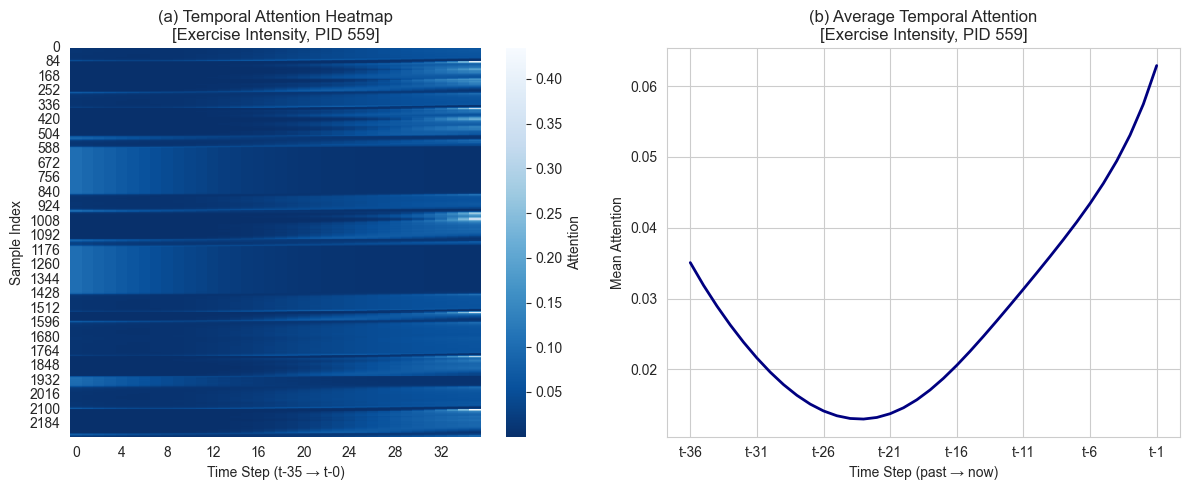

In [7]:
# Temporal attention visualization

# Config
pid = "559"
T = 36
modal_id = 4   # Select from 0 to 6 (index of FEATURES)

# Feature keys
FEATURES = ['glucose', 'meal_carbs', 'insulin_bolus', 'insulin_basal', 'exercise_intensity', 'gsr', 'skin_temp']

# Friendly feature names
FEATURE_NAMES = {
    'glucose': 'Blood Glucose',
    'meal_carbs': 'Meal Carbohydrates',
    'insulin_bolus': 'Insulin Bolus',
    'insulin_basal': 'Basal Insulin',
    'exercise_intensity': 'Exercise Intensity',
    'gsr': 'Galvanic Skin Response',
    'skin_temp': 'Skin Temperature'
}

# Get selected feature name
feature_key = FEATURES[modal_id]
feature_name = FEATURE_NAMES[feature_key]

# Load attention weights
attn = np.load(f"weights/modal_{modal_id+1}_temp_weights_pid{pid}_full.npy").squeeze()

# Compute mean attention over samples
mean_attn = attn.mean(axis=0)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1]})

# Figure 1: Heatmap
sns.heatmap(
    attn,
    cmap="Blues_r",
    ax=axes[0],
    xticklabels=4,
    cbar_kws={"label": "Attention"}
)
axes[0].set_title(f"(a) Temporal Attention Heatmap\n[{feature_name}, PID {pid}]")
axes[0].set_xlabel("Time Step (t-35 → t-0)")
axes[0].set_ylabel("Sample Index")

# Figure 2: Mean attention line plot
axes[1].plot(range(T), mean_attn, color="navy", linewidth=2)
axes[1].set_xticks([0, 5, 10, 15, 20, 25, 30, 35])
axes[1].set_xticklabels([f"t-{T-i}" for i in [0,5,10,15,20,25,30,35]])
axes[1].set_xlabel("Time Step (past → now)")
axes[1].set_ylabel("Mean Attention")
axes[1].set_title(f"(b) Average Temporal Attention\n[{feature_name}, PID {pid}]")
axes[1].grid(True)

plt.tight_layout()
plt.show()


C:\Users\12905\AppData\Local\Temp\ipykernel_24556\2435773125.py:59: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(


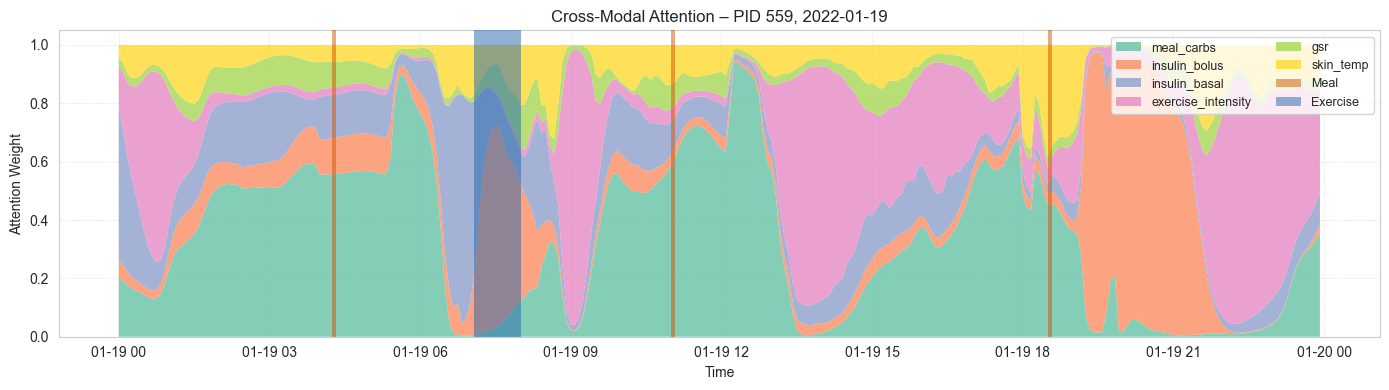

In [19]:
# Cross-modal attention visualization

# Parameters
pid = "559"
example_day_idx = 1
xattn_path = f"weights/cma_all_softmax_pid{pid}_full.npy"
modal_json = f"weights/xattn_modal_names_pid{pid}.json"
events_path = f"processed/patient_{pid}_events.csv"
df_path = f"processed/patient_{pid}_test_std.csv"

# Load data
attn = np.load(xattn_path).squeeze(1)  # (N, M-1)
with open(modal_json, "r") as f:
    modal_names = json.load(f)

df = pd.read_csv(df_path, index_col=0, parse_dates=True)
events = pd.read_csv(events_path, index_col=0, parse_dates=True)

# Align attention with test data length
df = df.iloc[-len(attn):]
events = events.iloc[-len(attn):]
attn_df = pd.DataFrame(attn, columns=modal_names, index=df.index)

# Select one day
example_day = attn_df.index.normalize().unique()[example_day_idx]
attn_day = attn_df[attn_df.index.normalize() == example_day]
events_day = events.loc[attn_day.index]

# Skip if too few samples
if len(attn_day) < 20:
    print("Insufficient data, please try another day")
else:
    fig, ax = plt.subplots(figsize=(14, 4))

    # Define event styles: only meal and exercise
    event_styles = {
        "meal_flag":     {"color": "#D35400", "label": "Meal",     "alpha": 0.5},
        "exercise_flag": {"color": "#2166AC", "label": "Exercise", "alpha": 0.5},
    }

    # Plot stacked attention
    set2_colors = plt.cm.Set2.colors
    ax.stackplot(
        attn_day.index,
        attn_day.values.T,
        labels=modal_names,
        colors=set2_colors[:len(modal_names)],
        alpha=0.8,
        linewidth=0,
        edgecolor='none',
        zorder=1
    )

    # Highlight event flags
    used_labels = set()
    for flag, style in event_styles.items():
        mask = events_day[flag] == 1
        for t in attn_day.index[mask]:
            ax.axvspan(
                t,
                t + pd.Timedelta(minutes=5),
                color=style["color"],
                alpha=style["alpha"],
                edgecolor="none",
                linewidth=0,
                zorder=3,
                label=style["label"] if style["label"] not in used_labels else None
            )
        used_labels.add(style["label"])

    # Format plot
    ax.set_title(f"Cross-Modal Attention – PID {pid}, {example_day.date()}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Attention Weight")
    ax.grid(True, linestyle='--', alpha=0.3)

    # Unique legend
    handles, labels = ax.get_legend_handles_labels()
    from collections import OrderedDict
    unique = OrderedDict()
    for h, l in zip(handles, labels):
        if l and l not in unique:
            unique[l] = h
    ax.legend(unique.values(), unique.keys(), loc='upper right', ncol=2, fontsize=9)

    plt.tight_layout()
    plt.show()


Loaded z_fused: shape = (2256, 64)
[Q1] Clustering done (k=4), Silhouette Score = 0.3164
[✓] State file saved to weights/state_pid559_K4.npy


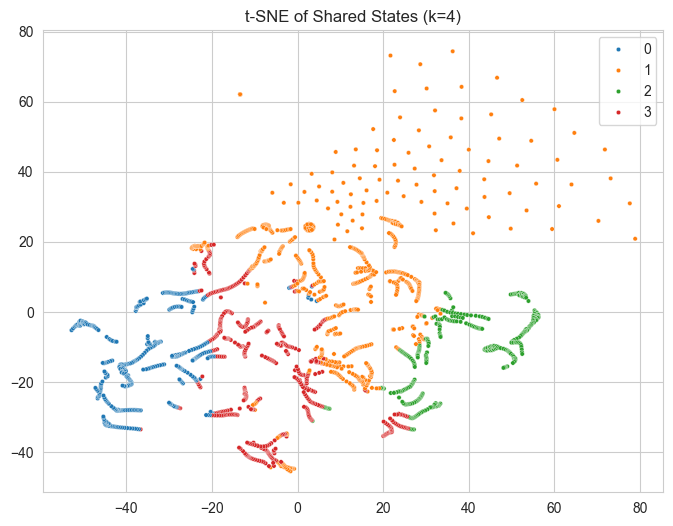

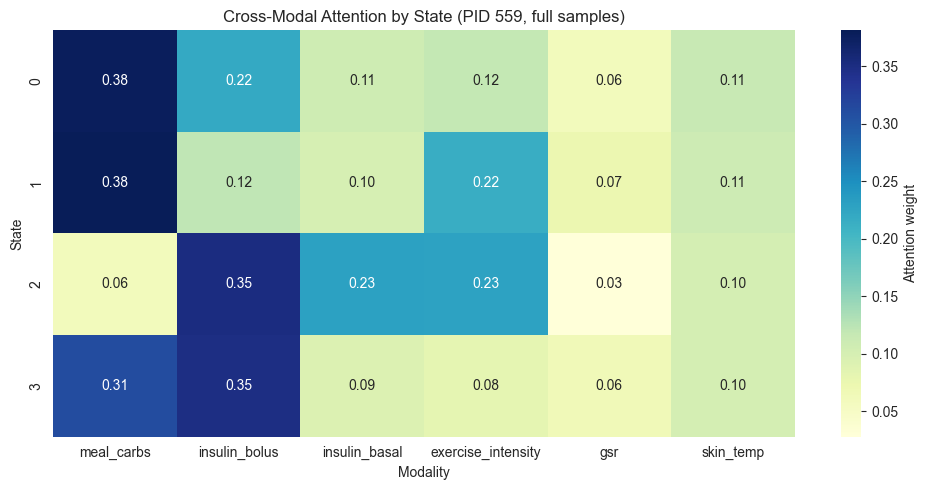

In [15]:
# Clustering & state-level CMA heatmap

# Config
PID = "559"  # patient ID
MODEL_TAG = ""  # optional model suffix
N_CLUSTERS = 4  # number of clusters

# 1 Load z_fused
z_fused = np.load(f"weights/fused_pid{PID}{'_' + MODEL_TAG if MODEL_TAG else ''}.npy")
print(f"Loaded z_fused: shape = {z_fused.shape}")

# 2 Clustering analysis
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
cluster_labels = kmeans.fit_predict(z_fused)
sil_score = silhouette_score(z_fused, cluster_labels)
print(f"[Q1] Clustering done (k={N_CLUSTERS}), Silhouette Score = {sil_score:.4f}")

# Save clustering results for later visualization
state_path = f"weights/state_pid{PID}_K{N_CLUSTERS}.npy"
np.save(state_path, cluster_labels)
print(f"[✓] State file saved to {state_path}")

# 3 Dimensionality reduction (t-SNE)
tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(z_fused)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=z_2d[:, 0], y=z_2d[:, 1], hue=cluster_labels, palette='tab10', s=10)
plt.title(f"t-SNE of Shared States (k={N_CLUSTERS})")
plt.savefig(f"tsne_shared_states_pid{PID}.png")
plt.show()

# Cross-modal attention heatmap per state

# Load state labels and attention weights
state_t = np.load(state_path)  # (N,)
xattn = np.load(f"weights/cma_all_softmax_pid{PID}_full.npy")  # (N, M-1)
xattn = xattn.squeeze(axis=1)

# Load modality names
with open(f"weights/xattn_modal_names_pid{PID}.json", "r") as f:
    modal_names = json.load(f)

# Create DataFrame
df = pd.DataFrame(xattn, columns=modal_names)
df["state"] = state_t

# Compute mean attention per state
attn_by_state = df.groupby("state")[modal_names].mean()

# Plot heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(attn_by_state, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Attention weight'})
plt.title(f"Cross-Modal Attention by State (PID {PID}, full samples)")
plt.xlabel("Modality")
plt.ylabel("State")
plt.tight_layout()
plt.show()


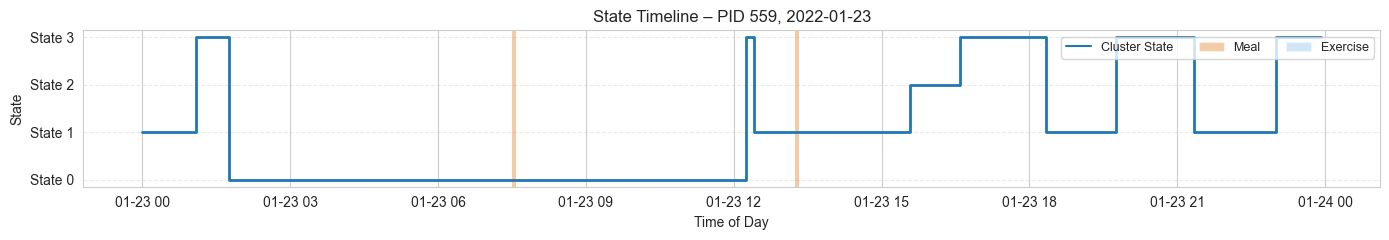

288


In [10]:
# Event overlay + state transition timeline

# Config
pid = "559"
K = 4
state_path = f"weights/state_pid{pid}_K{K}.npy"
df_path = f"processed/patient_{pid}_test_std.csv"
events_path = f"processed/patient_{pid}_events.csv"

# Load data
df = pd.read_csv(df_path, index_col=0, parse_dates=True)
state_t = np.load(state_path)
df = df.iloc[-len(state_t):].copy()
df["state"] = state_t

# Load event flags
events = pd.read_csv(events_path, index_col=0, parse_dates=True)
events = events.loc[df.index]  # align index

# Select one day
example_day = df.index.normalize().unique()[5]  # 6th day
df_day = df[df.index.normalize() == example_day].copy()
events_day = events.loc[df_day.index]

# Skip if data too short
if len(df_day) < 50:
    print("Not enough data for this day, try another")
else:
    fig, ax = plt.subplots(figsize=(14, 2.5))

    # Plot state transitions
    ax.step(df_day.index, df_day["state"], where='post', linewidth=2, label='Cluster State', color='C0', zorder=2)

    # Define event styles
    event_styles = {
        "meal_flag":     {"color": "#E67E22", "label": "Meal",     "alpha": 0.4},
        "exercise_flag": {"color": "#5DADE2", "label": "Exercise", "alpha": 0.3}
    }

    # Add event shaded areas
    patch_handles = [Patch(facecolor=style["color"], alpha=style["alpha"], label=style["label"])
                     for style in event_styles.values()]

    for flag, style in event_styles.items():
        mask = events_day[flag] == 1
        for t in df_day.index[mask]:
            ax.axvspan(
                t,
                t + pd.Timedelta(minutes=5),
                color=style["color"],
                alpha=style["alpha"],
                linewidth=0,
                zorder=1
            )

    # Axis formatting
    ax.set_title(f"State Timeline – PID {pid}, {example_day.date()}")
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("State")
    ax.set_yticks(range(K))
    ax.set_yticklabels([f"State {i}" for i in range(K)])
    ax.grid(True, axis='y', linestyle='--', alpha=0.4)

    # Legend
    line_handle = plt.Line2D([0], [0], color='C0', label='Cluster State')
    ax.legend(handles=[line_handle] + patch_handles, loc="upper right", ncol=3, fontsize=9)

    plt.tight_layout()
    plt.show()

print(len(df_day))  # show number of samples for the day


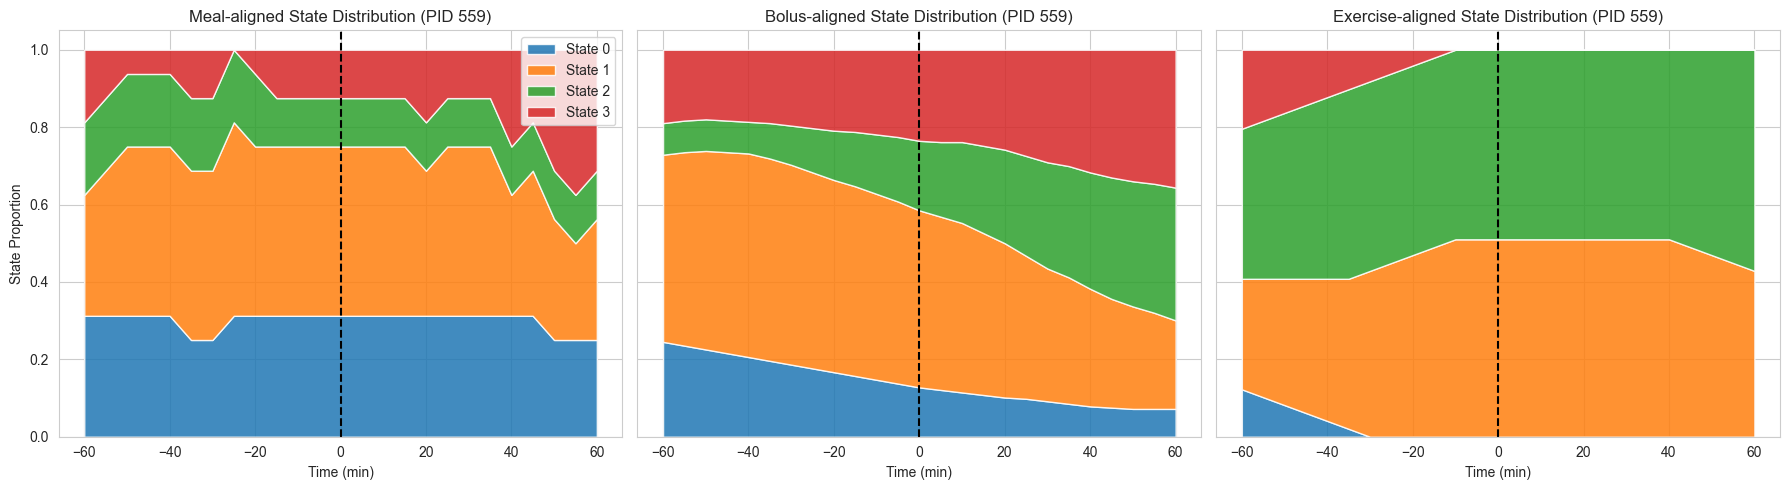

In [11]:
# Event-aligned state distribution plots

def plot_event_aligned_state_distribution(pid, event_name, state_K=4, window_min=60, step_min=5):
    # Load data
    df = pd.read_csv(f"processed/patient_{pid}_test_std.csv", index_col=0, parse_dates=True)
    state_t = np.load(f"weights/state_pid{pid}_K{state_K}.npy")
    df = df.iloc[-len(state_t):].copy()
    df["state"] = state_t

    # Detect events
    if event_name == "bolus":
        events = df[df["insulin_bolus"] > 0.1].index
    elif event_name == "exercise":
        events = df[df["exercise_intensity"] > 0.35].index
    elif event_name == "meal":
        events = df[df["meal_event"] > 0].index
    else:
        raise ValueError("Unknown event")

    # Build aligned window
    half_steps = window_min // step_min
    total_steps = half_steps * 2 + 1
    time_ticks = np.arange(-window_min, window_min + step_min, step_min)

    aligned = []
    for t0 in events:
        idx = df.index.get_loc(t0)
        if idx - half_steps < 0 or idx + half_steps >= len(df):
            continue
        aligned.append(df.iloc[idx - half_steps : idx + half_steps + 1]["state"].values)

    if len(aligned) == 0:
        print(f"[{event_name}] No valid event windows, skipped")
        return None

    aligned = np.stack(aligned)  # shape: (E, T)

    # Compute state proportions at each time step
    state_props = []
    for s in range(state_K):
        mask = (aligned == s)
        prop = mask.mean(axis=0)
        state_props.append(prop)

    return time_ticks, state_props

# Plot for three event types
pid = "559"
K = 4
window_min = 60
step_min = 5

event_list = ["meal", "bolus", "exercise"]
titles = ["Meal-aligned", "Bolus-aligned", "Exercise-aligned"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, event in enumerate(event_list):
    result = plot_event_aligned_state_distribution(pid, event, state_K=K, window_min=window_min, step_min=step_min)
    if result is not None:
        time_ticks, state_props = result
        axes[i].stackplot(time_ticks, state_props, labels=[f"State {s}" for s in range(K)], alpha=0.85)
        axes[i].axvline(0, color='k', linestyle='--')
        axes[i].set_title(f"{titles[i]} State Distribution (PID {pid})")
        axes[i].set_xlabel("Time (min)")
        if i == 0:
            axes[i].set_ylabel("State Proportion")
        axes[i].grid(True)

axes[0].legend(loc="upper right")
plt.tight_layout()
plt.show()


In [20]:
import nbformat
nb = nbformat.read("LSTM_ATTN.ipynb", as_version=4)
code_lines = sum(len(cell['source'].splitlines()) for cell in nb.cells if cell.cell_type == 'code')
print(f"{code_lines}")

1761
